## GL Points refitting

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['savefig.dpi'] = 300

In [29]:
old_coef = [1199.72839, 1025.18162, 0.00921] # O
# old_coef = [1236.25115, 1449.21864, 0.01644]# ef for the IPF formula

bwts = np.linspace(50, 200, 1000)

def ipf_formula(bwt, A, B, C):
    return (A - B * np.exp(-C * bwt))

### Refitting GL Points on new data

In [49]:
#Reading the data from the sorted CSV gold_standard_data_ipf_epf. (Ipf/Epf Meets, only totals >= 16 % WR total)
data = pd.read_csv("male data/gold_standard_data_ipf_epf.csv")
dataAugmentation = pd.read_csv("male data/trial.csv")
popt, pcov = curve_fit(ipf_formula, data['BodyweightKg'].values, data['TotalKg'], p0=old_coef)
poptdataAugmentation, pcovdataAugmentation = curve_fit(ipf_formula, dataAugmentation['BodyweightKg'].values, dataAugmentation['TotalKg'], p0=old_coef)
new_coef = popt
new_coef2 = poptdataAugmentation
print(new_coef2)
# print(new_coef)

[1.27324868e+03 1.13215322e+03 9.18324556e-03]


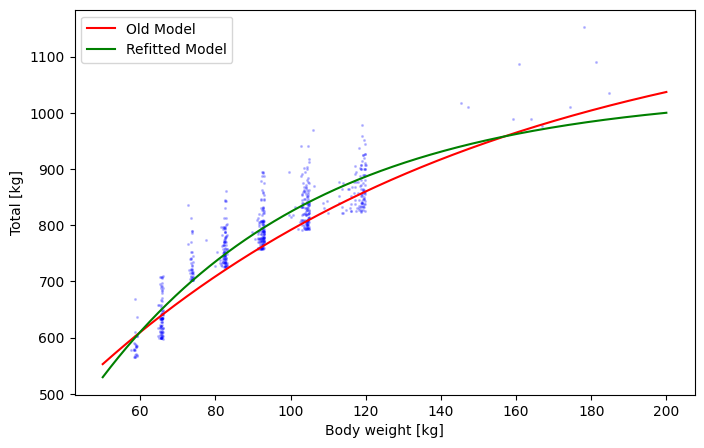

In [51]:
# plotting the old vs the new ipf gl formula. (No data augmentation)
plt.figure(figsize=(8, 5))
plt.plot(bwts, ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')
plt.plot(bwts, ipf_formula(bwts, *new_coef),  c = 'g', label='Refitted Model')
plt.scatter(data['BodyweightKg'].values, data['TotalKg'], alpha=0.2, s = 1.5, color="blue")
plt.ylabel("Total [kg]")
plt.xlabel("Body weight [kg]")
plt.legend()

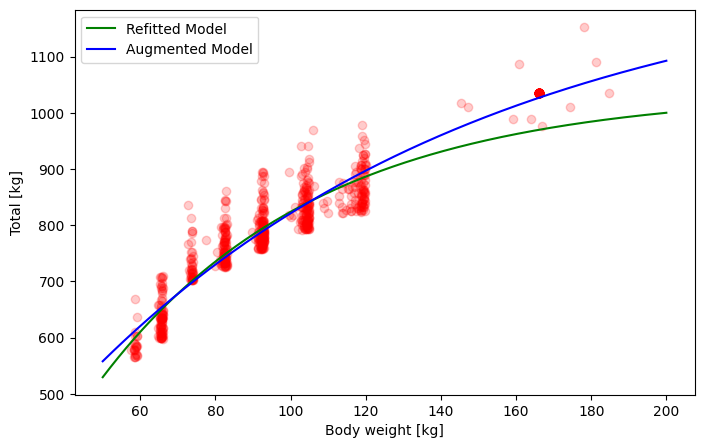

In [50]:
# plotting the old vs the new ipf gl formula. (with data augmentation to the 120+'s )
plt.figure(figsize=(8, 5))
plt.plot(bwts, ipf_formula(bwts, *new_coef),  c = 'g', label='Refitted Model')
plt.plot(bwts, ipf_formula(bwts, *new_coef2), c = 'b', label='Augmented Model')
plt.scatter(dataAugmentation['BodyweightKg'].values, dataAugmentation['TotalKg'], alpha=0.2, color="red")
plt.ylabel("Total [kg]")
plt.xlabel("Body weight [kg]")
plt.legend()

Converting this expected total to the GL coefficients and plotting them.

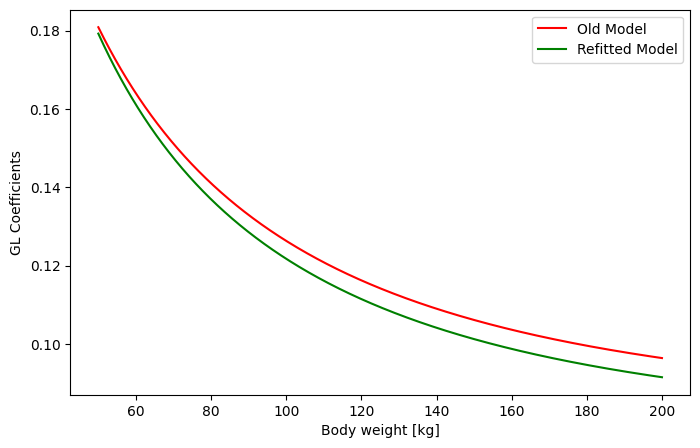

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(bwts, 100 / ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')
plt.plot(bwts, 100 / ipf_formula(bwts, *new_coef),  c = 'g', label='Refitted Model')
plt.ylabel("GL Coefficients")
plt.xlabel("Body weight [kg]")
plt.legend()

Now we can look at the expected change in GL points due to refitting for a given bodyweight. Note that this will be the same regardless of the total obtained, as the final score is just the coefficients multiplied with the total.

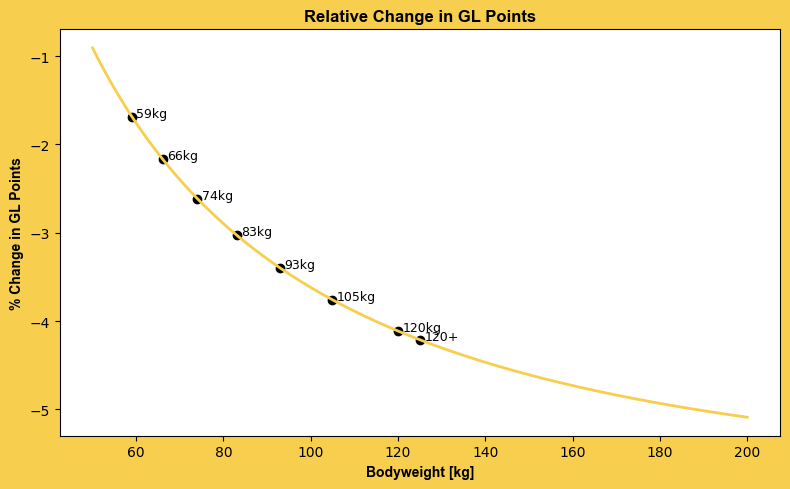

In [52]:
import matplotlib.pyplot as plt
import numpy as np

relative_diff = (100 / ipf_formula(bwts, *new_coef)) / (100 / ipf_formula(bwts, *old_coef))
percentage_change = 100 * (relative_diff - 1)

weight_classes = [59, 66, 74, 83, 93, 105, 120, 120.1]
weight_labels = [f"{w}kg" if w != 120.1 else "120+" for w in weight_classes]


plt.figure(figsize=(8, 5), facecolor='#f7ce4d')
plt.plot(bwts, percentage_change, label="Change in GL Points", color='#f7ce4d', lw=2)

for weight, label in zip(weight_classes, weight_labels):
    if weight == 120.1:
        idx = -500
    else:
        idx = np.argmin(np.abs(bwts - weight))

    plt.scatter(bwts[idx], percentage_change[idx], color='black')
    plt.text(bwts[idx] + 1, percentage_change[idx],
             label, ha='left', fontsize=9)

plt.xlabel("Bodyweight [kg]", fontweight='bold',fontfamily='Arial')
plt.ylabel("% Change in GL Points", fontweight='bold',fontfamily='Arial')
plt.title("Relative Change in GL Points", fontweight='bold',fontfamily='Arial')
plt.tight_layout()
plt.show()




### Weight Class Analysis
Looking at the distribution of the GL points in the weight classes and its changes due to refitting. We look at the entire dataset so we have a (relatively) unbiased sample.

In [17]:
data_full = pd.read_csv('male data/filtered_data_ipf_epf.csv')

In [18]:
data_full['GLold'] = data_full['TotalKg'] * (100 / ipf_formula(data_full['BodyweightKg'], *old_coef))
data_full['GLnew'] = data_full['TotalKg'] * (100 / ipf_formula(data_full['BodyweightKg'], *new_coef))

In [19]:
data['GLold'] = data['TotalKg'] * (100 / ipf_formula(data['BodyweightKg'], *old_coef))
data['GLnew'] = data['TotalKg'] * (100 / ipf_formula(data['BodyweightKg'], *new_coef))

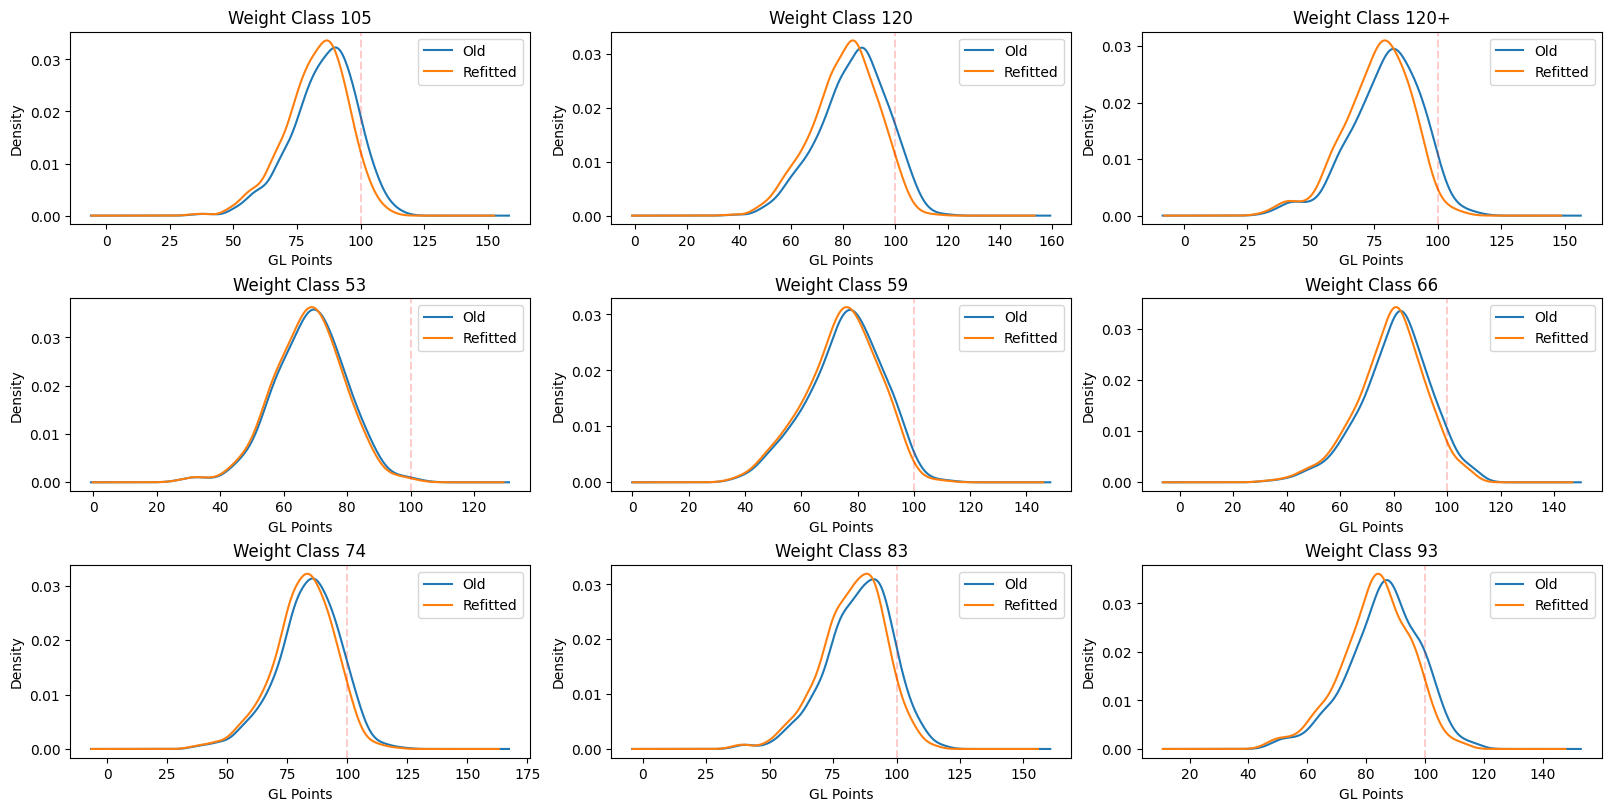

In [20]:
import matplotlib.pyplot as plt

# Define the grid dimensions (here 9 weightclasses, so 3x3)
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8), constrained_layout=True)

axes = axes.flatten()

for ax, (weight_class, group) in zip(axes, data_full.groupby('WeightClassKg')):
    group['GLold'].plot(kind='kde', ax=ax, label = 'Old')
    group['GLnew'].plot(kind='kde', ax=ax, label = 'Refitted')
    ax.axvline(100, ymin = 0, color = 'red', linestyle = 'dashed', alpha = 0.2)
    ax.set_title(f'Weight Class {weight_class}')
    ax.set_xlabel('GL Points')
    ax.set_ylabel('Density')
    ax.legend()

# Show the plots
plt.show()


We see the distributions become fairer, as we generally want the distribution to be symmetric around 100 (given an ideal data split). They aren't very symmetric, but the volume of probability at either sides does tend to be more equal with the refitted variant. This does show the (on average) favoured weight classes by this formula (e.g. 93).

In [21]:
import pandas as pd

# Load the data
data_all = pd.read_csv(
    'male data/all_meets_male_ipf_epf.csv',
    dtype={'BodyweightKg': 'float64', 'TotalKg': 'float64'},
    low_memory=False
)

# Calculate GLold and GLnew values
data_all['GLold'] = data_all['TotalKg'] * (100 / ipf_formula(data_all['BodyweightKg'], *old_coef))
data_all['GLnew'] = data_all['TotalKg'] * (100 / ipf_formula(data_all['BodyweightKg'], *new_coef))

# Filter data for specific meet
specific_meet = "World Classic Powerlifting Championships"
specific_date = "2024-06-15"

filtered_data = data_all[(data_all['MeetName'].str.contains(specific_meet, case=False, na=False)) &
                     (data_all['Date'] == specific_date)]
# Sort independently for GLold and GLnew
sorted_by_glold = filtered_data.sort_values(by='GLold', ascending=False)
sorted_by_glnew = filtered_data.sort_values(by='GLnew', ascending=False)

# Select the top 10 for each
top_10_glold = sorted_by_glold[['Name', 'TotalKg', 'WeightClassKg', 'MeetName', 'GLold']].head(10)
top_10_glnew = sorted_by_glnew[['Name', 'TotalKg', 'WeightClassKg', 'MeetName', 'GLnew']].head(10)

# Display the top 10 for GLold and GLnew
display(top_10_glold)
display(top_10_glnew)


,Name,TotalKg,WeightClassKg,MeetName,GLold
1599,austin perkins #1,836.0,74,world classic powerlifting championships,123.824594
1600,kjell egil bakkelund,812.5,74,world classic powerlifting championships,119.661357
1712,bobb matthews,970.0,120,world classic powerlifting championships,119.286428
1648,gustav hedlund,895.0,93,world classic powerlifting championships,117.393501
1649,emil krastev,895.0,93,world classic powerlifting championships,117.238831
1623,jurins kengamu,845.0,83,world classic powerlifting championships,117.220534
1682,ashton rouska,940.5,105,world classic powerlifting championships,117.219746
1624,russel orhii,843.5,83,world classic powerlifting championships,117.012450
1650,brandon pitre,887.5,93,world classic powerlifting championships,116.533003
1683,anatolii novopismennyi,940.5,105,world classic powerlifting championships,116.272912


,Name,TotalKg,WeightClassKg,MeetName,GLnew
1599,austin perkins #1,836.0,74,world classic powerlifting championships,120.668547
1600,kjell egil bakkelund,812.5,74,world classic powerlifting championships,116.561630
1712,bobb matthews,970.0,120,world classic powerlifting championships,114.773960
1623,jurins kengamu,845.0,83,world classic powerlifting championships,113.689241
1624,russel orhii,843.5,83,world classic powerlifting championships,113.487426
1648,gustav hedlund,895.0,93,world classic powerlifting championships,113.421836
1649,emil krastev,895.0,93,world classic powerlifting championships,113.262486
1601,timothy monigatti,790.0,74,world classic powerlifting championships,113.119315
1682,ashton rouska,940.5,105,world classic powerlifting championships,112.880221
1650,brandon pitre,887.5,93,world classic powerlifting championships,112.598368


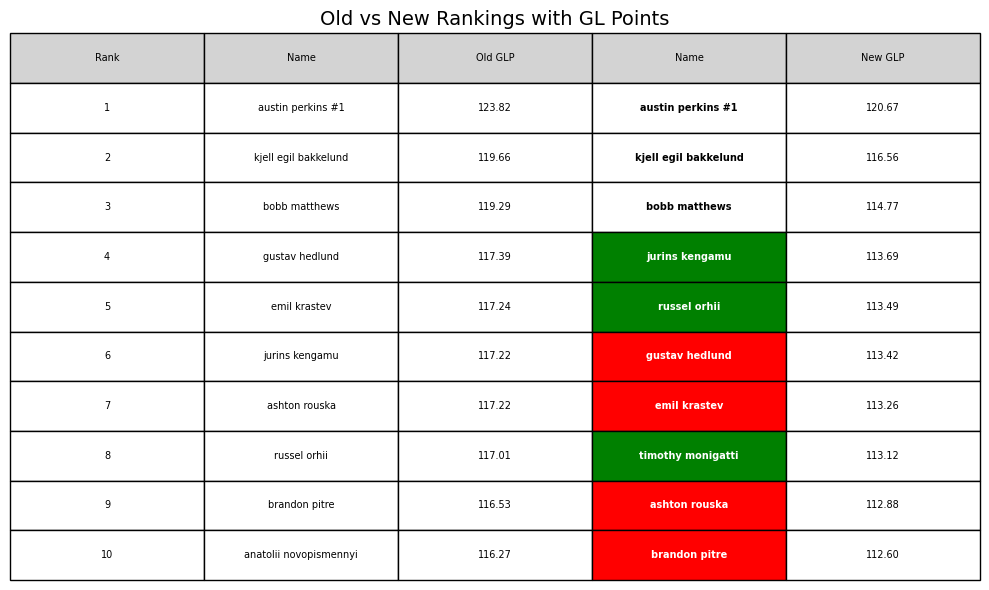

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Extract the names and GLP values
# Ensure top_10_glold and top_10_glnew are correctly sized
top_10_glold = top_10_glold.head(10).reset_index(drop=True)
top_10_glnew = top_10_glnew.head(10).reset_index(drop=True)

# Extract the names and GLP values
glold_names = top_10_glold['Name']
glold_glp = top_10_glold['GLold']

glnew_names = top_10_glnew['Name']
glnew_glp = top_10_glnew['GLnew']

# Create the comparison DataFrame
comparison = pd.DataFrame({
    'GLold_Ranking': range(1, 11),
    'GLold': glold_names,
    'GLold_GLP': glold_glp,
    'GLnew': glnew_names,
    'GLnew_GLP': glnew_glp
})


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axes for a clean table look

# Create the table
table = Table(ax, bbox=[0, 0, 1, 1])

# Column headers
columns = ["Rank", "Name", "Old GLP", "Name", "New GLP"]
for col_idx, col_name in enumerate(columns):
    table.add_cell(0, col_idx, width=0.2, height=0.05, text=col_name, loc='center', facecolor='lightgrey')

for i, row in comparison.iterrows():
    if row['GLnew'] not in comparison['GLold'].values:
        color = 'green'
        text_color = 'white'
        bg_color = 'green'
    else:
        old_rank = comparison[comparison['GLold'] == row['GLnew']].index[0]
        if old_rank > i:
            color = 'green'
            text_color = 'white'
            bg_color = 'green'
        elif old_rank < i:
            color = 'red'
            text_color = 'white'
            bg_color = 'red'
        else:
            bg_color = 'white'
            text_color = 'black'

    table.add_cell(i + 1, 0, width=0.2, height=0.05, text=f"{i + 1}", loc='center')

    table.add_cell(i + 1, 1, width=0.2, height=0.05, text=f"{row['GLold']}", loc='center')
    table.add_cell(i + 1, 2, width=0.2, height=0.05, text=f"{row['GLold_GLP']:.2f}", loc='center')

    new_cell = table.add_cell(i + 1, 3, width=0.2, height=0.05, text=f"{row['GLnew']}", loc='center', facecolor=bg_color)
    table.add_cell(i + 1, 4, width=0.2, height=0.05, text=f"{row['GLnew_GLP']:.2f}", loc='center')

    new_cell.set_text_props(fontweight='bold', color=text_color)

ax.add_table(table)

plt.title('Old vs New Rankings with GL Points', fontsize=14)

plt.tight_layout()
plt.show()


In [23]:
data_gl_rank =  pd.read_csv(
    'male data/all_meets_male_ipf_epf.csv',
    dtype={'BodyweightKg': 'float64', 'TotalKg': 'float64'},
    low_memory=False
)

data_gl_rank['GLold'] = data_gl_rank['TotalKg'] * (100 / ipf_formula(data_gl_rank['BodyweightKg'], *old_coef))
data_gl_rank['GLnew'] = data_gl_rank['TotalKg'] * (100 / ipf_formula(data_gl_rank['BodyweightKg'], *new_coef))


In [24]:
sorted_data = data_gl_rank.sort_values(by='GLnew', ascending=False)
top_10_distinct = sorted_data.drop_duplicates(subset='Name', keep='first')

top_10_distinct = top_10_distinct.head()
display(top_10_distinct)

,Name,BodyweightKg,TotalKg,WeightClassKg,Federation,Date,MeetName,GLold,GLnew
1599,austin perkins #1,72.75,836.0,74,IPF,2024-06-15,world classic powerlifting championships,123.824594,120.668547
88102,taylor atwood,73.63,838.5,74,USAPL,2021-06-14,raw nationals,123.420806,120.218612
79458,jesse norris,89.30,914.0,90,USAPL,2014-12-13,idaho state open/high school championships,121.978532,117.988504
122249,ashton rouska,98.45,950.5,105,USAPL,2020-11-14,virginia winter wrecker,120.972761,116.649871
1600,kjell egil bakkelund,73.55,812.5,74,IPF,2024-06-15,world classic powerlifting championships,119.661357,116.561630


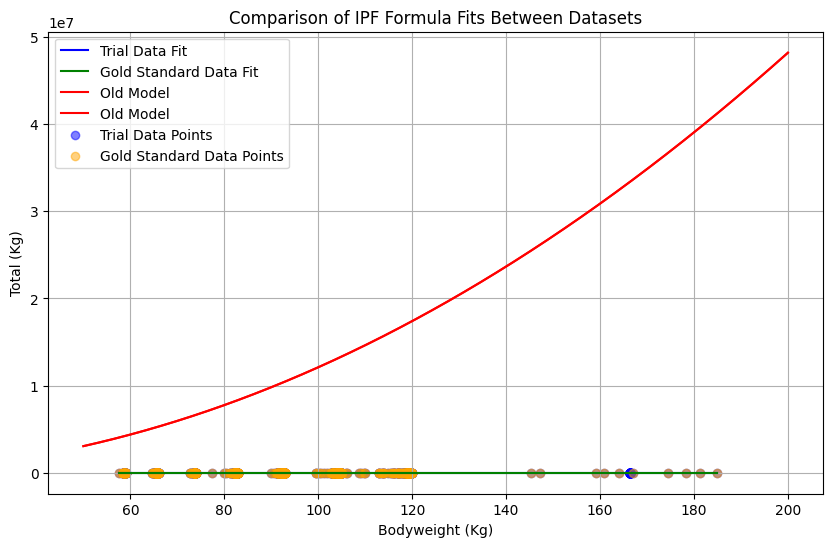

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the IPF formula
def ipf_formula(bodyweight, a, b, c):
    return a * (bodyweight**2) + b * bodyweight + c

# Initial coefficients (replace `old_coef` with your initial guess values)
old_coef = [1199.72839, 1025.18162, 0.00921] # Old coef for the IPF formula


# Load the datasets
trial_data = pd.read_csv("male data/trial.csv")
gold_standard_data = pd.read_csv("male data/gold_standard_data_ipf_epf.csv")

# Fit the formula to each dataset
popt_trial, _ = curve_fit(ipf_formula, trial_data['BodyweightKg'].values, trial_data['TotalKg'], p0=old_coef)
popt
# Generate a range of bodyweight values for predictions
bodyweight_range = np.linspace(min(trial_data['BodyweightKg'].min(), gold_standard_data['BodyweightKg'].min()),
                               max(trial_data['BodyweightKg'].max(), gold_standard_data['BodyweightKg'].max()), 100)

# Predict the TotalKg for each dataset using the fitted formula
predicted_trial = ipf_formula(bodyweight_range, *popt_trial)
predicted_gold = ipf_formula(bodyweight_range, *popt_gold)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(bodyweight_range, predicted_trial, label='Trial Data Fit', color='blue')
plt.plot(bodyweight_range, predicted_gold, label='Gold Standard Data Fit', color='green')
plt.plot(bwts, ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')
plt.plot(bwts, ipf_formula(bwts, *old_coef), c = 'r', label='Old Model')

plt.scatter(trial_data['BodyweightKg'], trial_data['TotalKg'], label='Trial Data Points', color='blue', alpha=0.5)
plt.scatter(gold_standard_data['BodyweightKg'], gold_standard_data['TotalKg'], label='Gold Standard Data Points', color='orange', alpha=0.5)
plt.xlabel('Bodyweight (Kg)')
plt.ylabel('Total (Kg)')
plt.title('Comparison of IPF Formula Fits Between Datasets')
plt.legend()
plt.grid(True)
plt.show()




